# Notebook "2_Besoin_3_cmb_10_profils"


## Description

Ce notebook se focalise sur l'étude de la CMB à 10 profils commencée par Abdel lors de la première mission

## Structure du notebook

Ce notebook est construit de plusieurs parties :
- I. Import des bibliothèques
- II. Chargement des données et des profils
- III. Application du lissage

## Prérequis

### Source de données

Pour que le notebook fonctionne, il est nécessaire que le fichier project_config.yml soit situé au même niveau que ce notebook : ce fichier permet la connexion à la source de données.

### Installation des prérequis techniques

Le notebook fonctionne sur Python 3.7 avec les bibliothèques suivantes :
- pandas
- psycopg2
- sqlachemy
- sklearn
- numpy
- yaml
- matplotlib

# I - Import des bibliothèques

In [1]:
# handling postgres database
import psycopg2
import pandas.io.sql as sqlio
import pandas as pd 
from sqlalchemy import create_engine
from io import StringIO
from sklearn.linear_model import Lasso
from sklearn import metrics
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yaml
from IPython.display import clear_output

Profiles = ['HOA',
    'BBOA',
    'OPOA/OBBOA',
    'BSOA (marine)',
    'BSOA (isoprene)',
    'ASOA (nitro-PAHs)',
    'ASOA (oxy-PAHs)',
    'ASOA (phenolic compounds oxidation)',
    'ASOA (toluene oxidation)',
    'SOA (unknown)']

# II - Chargement des données et des profils

## II.a Recherche des identifiants de connexion

In [2]:
with open(r'.\project_config.yml') as file:
    dbInfo = yaml.load(file, Loader=yaml.FullLoader)
    HOSTNAME = dbInfo["project-database"]["hostname"]
    DATABASE = dbInfo["project-database"]["name"]
    USER = dbInfo["project-database"]["user"]
    PASSWORD = dbInfo["project-database"]["password"]
    PORT = "5432"

## II.b Recherche des profils dans le fichier excel

In [3]:
df = pd.read_excel('./pmf_profiles.xlsx', engine='openpyxl')

df.drop(columns=['Unnamed: 0'], inplace=True)
df.rename(columns={'Unnamed: 1': 'amus'}, inplace=True)
df = df[["amus"] + Profiles]
pro = df.columns[1:]

In [4]:
pro

Index(['HOA', 'BBOA', 'OPOA/OBBOA', 'BSOA (marine)', 'BSOA (isoprene)',
       'ASOA (nitro-PAHs)', 'ASOA (oxy-PAHs)',
       'ASOA (phenolic compounds oxidation)', 'ASOA (toluene oxidation)',
       'SOA (unknown)'],
      dtype='object')

In [5]:
df

,amus,HOA,BBOA,OPOA/OBBOA,BSOA (marine),BSOA (isoprene),ASOA (nitro-PAHs),ASOA (oxy-PAHs),ASOA (phenolic compounds oxidation),ASOA (toluene oxidation),SOA (unknown)
0,16,0.000000e+00,0.000000,0.006772,0.013374,0.008667,9.946996e-03,0.008455,0.008872,1.048894e-02,1.359988e-02
1,17,0.000000e+00,0.000000,0.045095,0.089056,0.057710,6.623502e-02,0.056304,0.059076,6.984539e-02,9.055989e-02
2,18,6.293874e-08,0.013155,0.176786,0.351232,0.216361,2.619790e-01,0.217218,0.215837,2.804571e-01,3.531707e-01
3,24,4.937824e-04,0.002655,0.001114,0.000634,0.002346,1.593717e-03,0.000255,0.000475,0.000000e+00,1.888626e-03
4,25,0.000000e+00,0.003464,0.006133,0.002839,0.005909,2.876643e-03,0.002968,0.006352,5.061772e-03,2.358684e-03
5,26,7.960529e-03,0.038599,0.032386,0.012250,0.026877,1.604203e-02,0.016746,0.019746,2.411652e-02,1.437292e-02
6,27,5.475362e-02,0.065419,0.055010,0.022972,0.041442,3.348157e-02,0.043343,0.045083,4.159869e-02,2.250066e-02
7,30,4.585967e-04,0.000000,0.001952,0.001706,0.006823,1.399357e-03,0.000000,0.006325,0.000000e+00,9.491554e-04
8,31,4.320236e-03,0.040291,0.030394,0.000922,0.039329,1.165991e-02,0.000000,0.000000,1.489108e-02,1.086331e-02
9,41,9.986822e-02,0.071034,0.021630,0.009179,0.042019,3.061105e-02,0.036695,0.036373,1.281386e-02,1.044041e-02


# III. Application du lissage

## III.a Récupération des données en DB

In [6]:
## SELECTION DE LA DATE
start_date = '2015-03-07'
end_date = '2015-03-21'
## FIN DE LA SELECTION DE LA DATE

sql = f"""SELECT to_char(date, 'YYYY-MM-DD HH24:00:00') FROM(SELECT date FROM public.data_receptor 
          WHERE date>='{start_date}' AND date<='{end_date}' GROUP BY 1 ORDER BY 1) AS foo;"""
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
df_dates = sqlio.read_sql_query(sql, connection)
connection.close()
dates = df_dates.T.values[0]

## III.b Mise en place du lissage

In [12]:
contirubtion1 = [[] for i in pro]
connection = psycopg2.connect(user = USER, password = PASSWORD, host = HOSTNAME, port = PORT, database = DATABASE)
for date in dates:    
    sql = f"""SELECT * FROM public.data_receptor where date = '{date}' 
        order by mass;"""
    df_receptor_data = sqlio.read_sql_query(sql, connection)
    df_receptor_data = df_receptor_data[df_receptor_data.columns]
    cor = df.merge(df_receptor_data, left_on='amus', right_on='mass').drop(columns=['mass', 'amus'])


    X_train = cor[pro].values
    y_train = cor['value'].values.reshape(-1,1)

    alpha = 0.0001
    lasso = Lasso(fit_intercept=False, alpha=alpha, positive=True)     # We train without intercept and we shoose to have only positive values
    lasso.fit(X_train, y_train)                                        #training the algorithm
    clear_output(wait=True)      
    print(date)
    for n, prof in enumerate(pro):
        contirubtion1[n].append(lasso.coef_[n])
connection.close()

In [11]:
contirubtion1[n]

[]

## III.c Affichage des valeurs

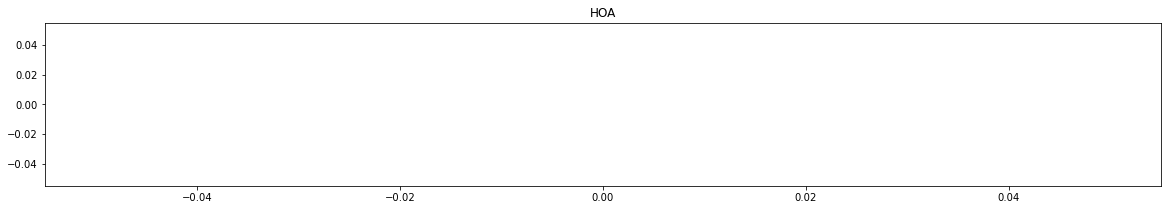

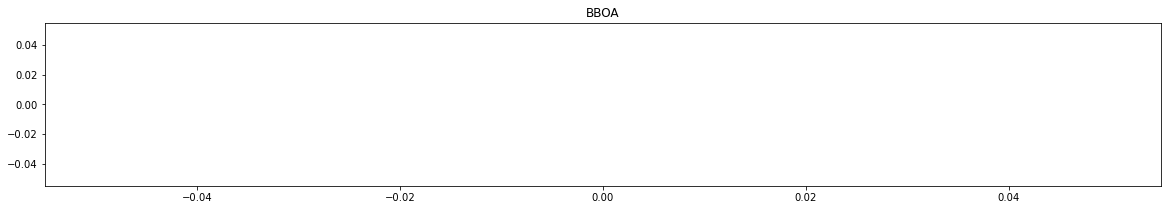

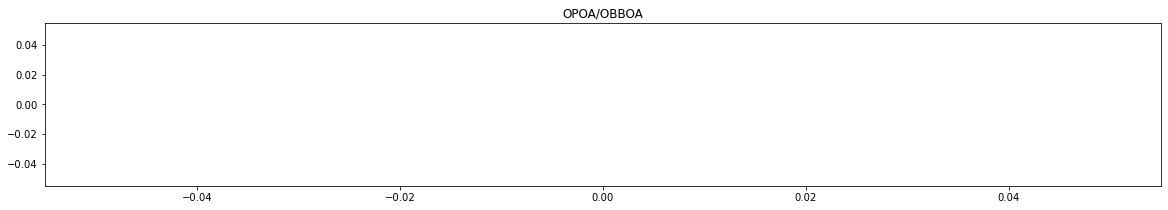

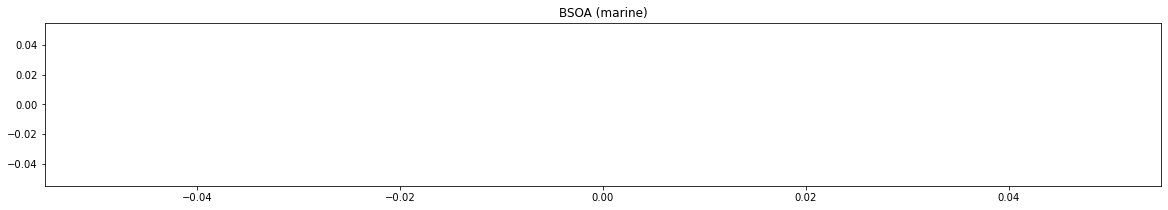

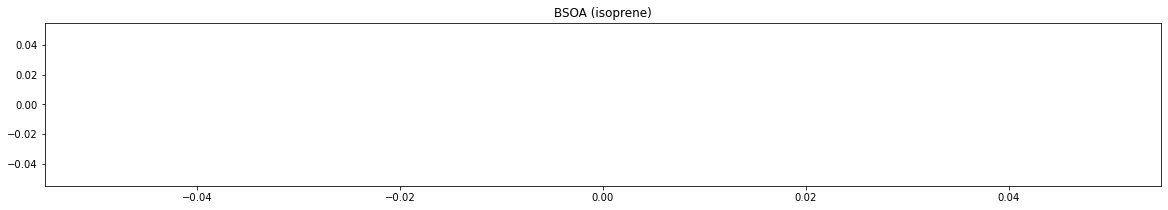

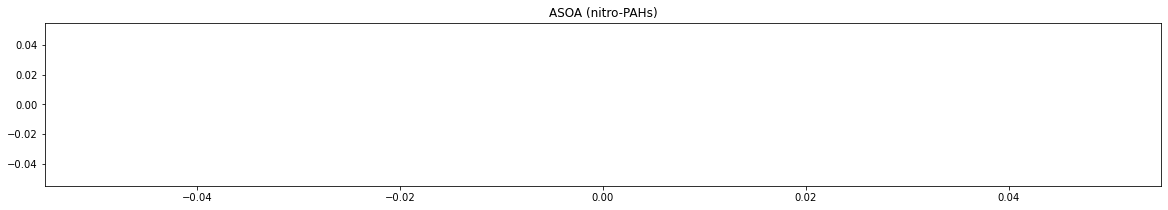

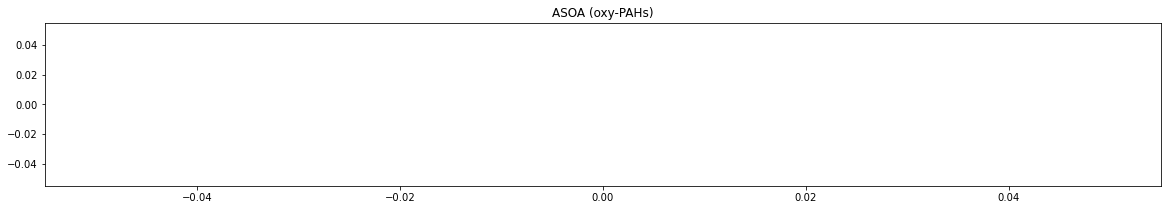

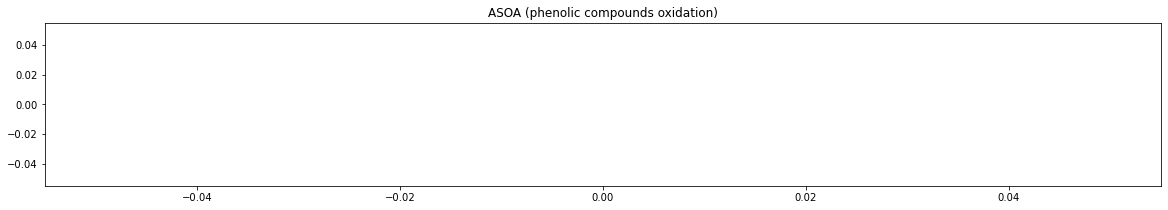

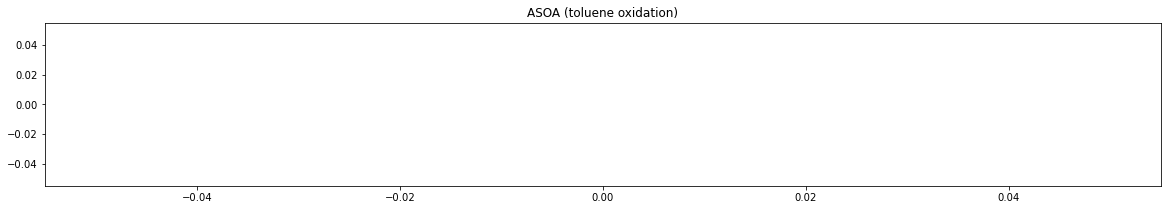

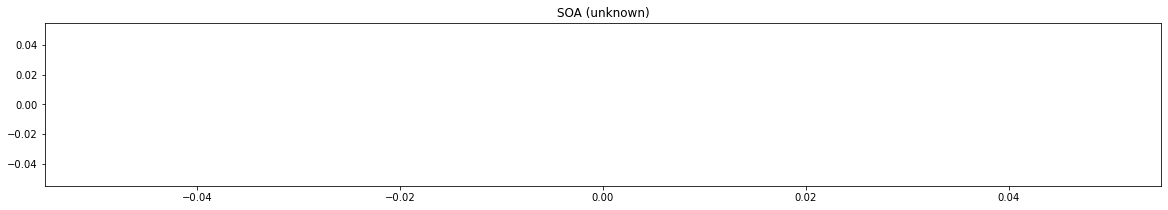

In [8]:
plt.rcParams["figure.figsize"] = (20,3)
for n, prof in enumerate(pro):
#     fig.size(7,10)
    plt.title(prof)
    plt.plot(contirubtion1[n])
    plt.show()

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\matplotlib\axes\_axes.py:2921: RuntimeWarning: invalid value encountered in greater
  if sx > 1:


ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values


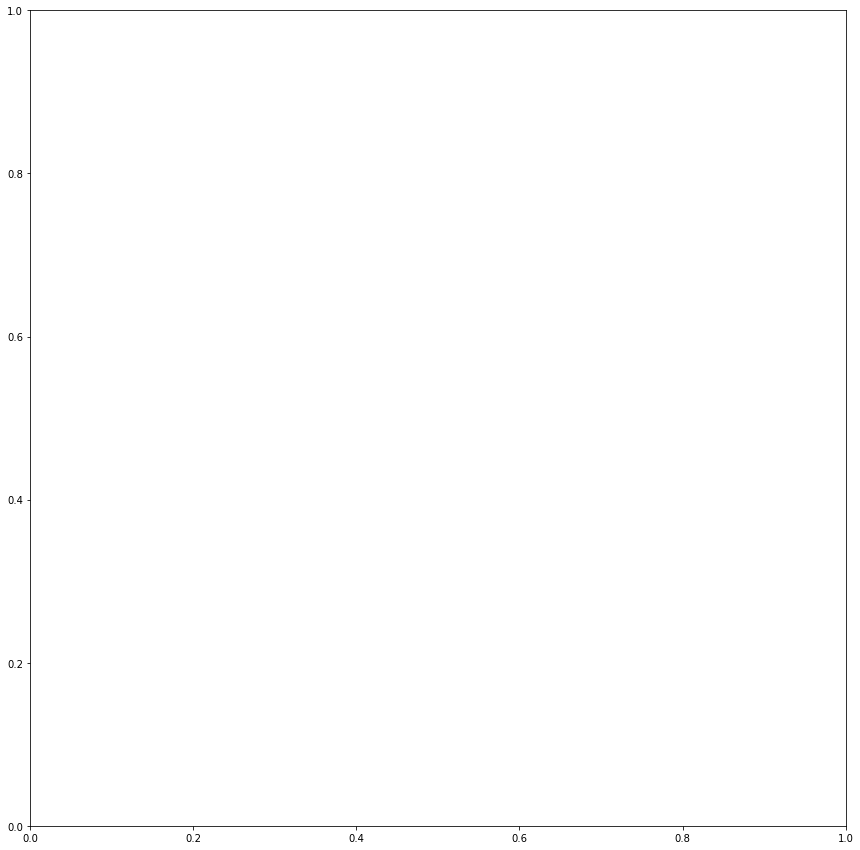

In [9]:
mean_contribution = np.mean(contirubtion1, axis=1)
proportion = mean_contribution * 100 / np.sum(mean_contribution)
plt.rcParams["figure.figsize"] = (15,15)
plt.pie(proportion, labels=[profil + " - " + str(proportion[i]) + "%" for i, profil in enumerate(pro)])
plt.show() 

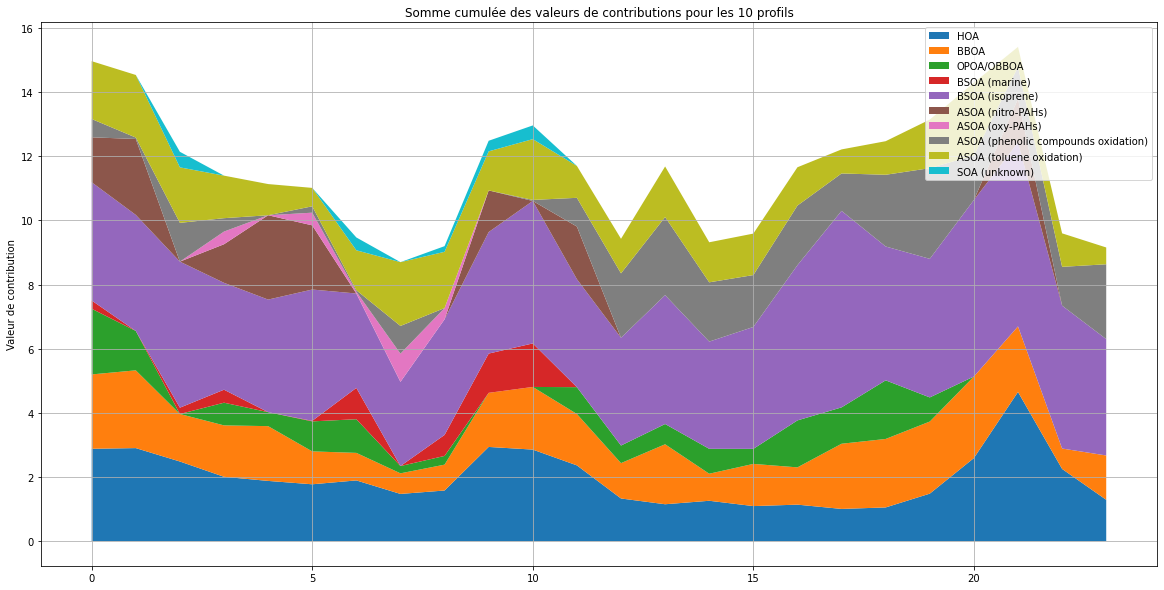

In [ ]:
cumsum_contribution = np.cumsum(contirubtion1, axis=0)
plt.rcParams["figure.figsize"] = (20, 10)
for n, prof in enumerate(pro):
    # plt.plot(cumsum_contribution[n])
    if n == 0:
        plt.fill_between(range(len(cumsum_contribution[0])), cumsum_contribution[n], 0, label=prof)
    else:
        plt.fill_between(range(len(cumsum_contribution[0])), cumsum_contribution[n], cumsum_contribution[n-1], label=prof)
plt.grid()
plt.title("Somme cumulée des valeurs de contributions pour les 10 profils")
plt.ylabel("Valeur de contribution")
plt.legend()
plt.show()

In [ ]:
df = pd.DataFrame(data=np.transpose(contirubtion1), columns=Profiles)
df["date"] = dates

In [ ]:
df.to_csv("analyse_cmb_10_profils.csv")